In [ ]:
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
from matplotlib import path
import random
import math

def cSpaceConvert(robotV, obsV):
    # robotV, robot vertices
    # obsV, pairs an obstacle's vertices
    
    # check if there's no robot input
    if (len(robotV)==0):
        print("No input robot vertices")
        return None
    
    # Compute Inverse of Robot Vercies w.r.t. Reference Point
    arRobotV = np.array(robotV)
    arObsV = np.array(obsV)
    irRobotV = arRobotV[0] - arRobotV
    
    # Compute Minkowski Sums
    retAr = np.zeros((0, 2))
    for i in irRobotV: retAr = np.concatenate((retAr, arObsV + i), axis=0)
    
    return retAr.tolist()
def plotCSpace(robotV, obsV):
    # robotV, robot vertices
    # obsV, pairs an obstacle's vertices

    # Compute and Draw C-Space
    points = cSpaceConvert(robotV, obsV)
    hull = ConvexHull(points)
    count = 0
    plt.subplot(122)
    for simplex in hull.simplices:
        iniPt = [points[simplex[0]][0], points[simplex[1]][0]]
        endPt = [points[simplex[0]][1], points[simplex[1]][1]]
        if count == 0 :
            plt.plot(iniPt, endPt, 'g-',label='c-space')
        else:
            plt.plot(iniPt, endPt, 'g-')
        count += 1
    # Draw Robot Reference Point, Robot, and Obstacle
    plt.xlabel('x')
    plt.ylabel('y')

    plt.title('c-space(after)')
    
    plt.legend()
    plt.subplot(121)
    plt.plot(robotV[0][0], robotV[0][1], 'ro', alpha=.25, markersize=20,label='reference')
    
    count = 0
    for i in range(len(robotV)-1, -1, -1):
        if count == 0:
            plt.plot([robotV[i][0], robotV[i-1][0]], [robotV[i][1], robotV[i-1][1]], 'k--', label='robot')
        else:
            plt.plot([robotV[i][0], robotV[i-1][0]], [robotV[i][1], robotV[i-1][1]], 'k--')
        count += 1
    
    count = 0
    for i in range(len(obsV)-1, -1, -1):
        if count == 0:
            plt.plot([obsV[i][0], obsV[i-1][0]], [obsV[i][1], obsV[i-1][1]], 'r--',label='obstacle')
        else:
            plt.plot([obsV[i][0], obsV[i-1][0]], [obsV[i][1], obsV[i-1][1]], 'r--')
        count += 1
    plt.xlabel('x')
    plt.ylabel('y')

    plt.title('work-space(before)')
    
    plt.legend()
    plt.savefig('./1.png')
    plt.show()
    # return True

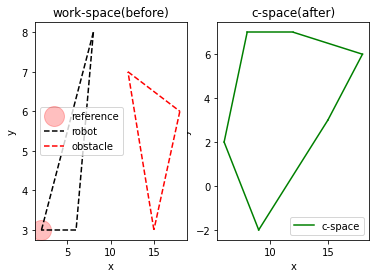

In [ ]:
testRobot = [[2, 3], [6, 3], [8, 8]]
testObs = [[18, 6], [12, 7], [15, 3]]
plotCSpace(testRobot, testObs)

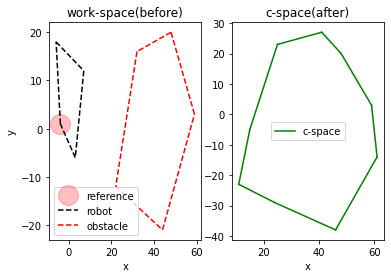

In [ ]:
testRobot = [[-4, 1], [3, -6], [7, 12], [-6, 18]]
testObs = [[32, 16], [48, 20], [59, 3], [44, -21],  [22, -12]]
plotCSpace(testRobot, testObs)

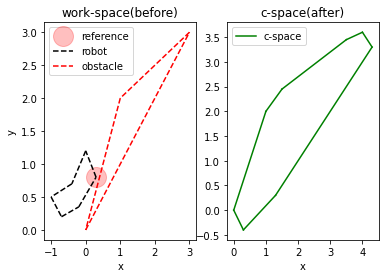

In [ ]:
testRobot = [[0.3, 0.8], [-0.2, 0.35], [-0.7, 0.2], [-1, 0.5], [-0.4, 0.7], [0, 1.2]]
testObs = [[1, 2], [3, 3], [0, 0]]
plotCSpace(testRobot, testObs)

In [ ]:
def Bug2(start_pos, goal_pos, obs, d, delta):
    
    # Compute rotation matrix
    rot_mat = np.array([[math.cos(delta), -math.sin(delta)],[math.sin(delta), math.cos(delta)]])
    inv_rot_mat = np.array([[math.cos(delta), math.sin(delta)],[-math.sin(delta), math.cos(delta)]])
    
    # Compute initial m-line
    v_mline = goal_pos - start_pos
    norm_v_mline = v_mline / np.linalg.norm(v_mline)
    obsCheck = path.Path(obs)
    
    stepSeq = []
    # Initialize current position and m-line
    current_pos = np.copy(start_pos)
    prev_step_v = np.copy(norm_v_mline)
    on_m_line_flg = True
    prevHead = np.linalg.norm(v_mline)
    while (True):
        stepSeq.append(np.copy(current_pos).tolist())      
        # Compute if the robot can reach the goal within single step
        v_goal = goal_pos - current_pos
        if (np.linalg.norm(v_goal) < d):
            current_pos = np.copy(goal_pos)
            stepSeq.append(current_pos.tolist())
            break
                
        # Normalization of current vector
        norm_v_goal = v_goal / np.linalg.norm(v_goal)

        if (on_m_line_flg):
            move_v = np.copy(norm_v_mline)
            while (obsCheck.contains_points([(current_pos + d*move_v).tolist()])):
                on_m_line_flg = False
                move_v = np.matmul(rot_mat, move_v)
                prevHead = np.linalg.norm(goal_pos - current_pos - d*move_v)
            current_pos += d*move_v
            prev_step_v = np.copy(move_v)

        # Not on m-line: tracing around the obstacle
        else:
            move_v = np.copy(prev_step_v)
            # Rotate on left side until free
            while (obsCheck.contains_points([(current_pos + d*prev_step_v).tolist()])):
                prev_step_v = np.copy(move_v)
                move_v = np.matmul(rot_mat, prev_step_v)
                
            prev_step_v = np.copy(move_v)
            # Rotate on right side until blocked
            while (not obsCheck.contains_points([(current_pos + d*move_v).tolist()]) and not obsCheck.contains_points([(current_pos + 0.1*move_v).tolist()])):
                prev_step_v = np.copy(move_v)
                move_v = np.matmul(inv_rot_mat, prev_step_v)
            move_v = np.copy(prev_step_v)
            # Update current position
            prev_pos = np.copy(current_pos)
            current_pos += d*move_v
            # Check if the robot has passed m-line, if so, update the m-line to be new one.
            if (np.cross(goal_pos-current_pos, norm_v_mline)*np.cross(goal_pos-prev_pos, norm_v_mline)<0 and np.linalg.norm(goal_pos-current_pos) < prevHead):
                v_mline = goal_pos - current_pos
                norm_v_mline = v_mline / np.linalg.norm(v_mline)
                prevHead = np.linalg.norm(v_mline)
                on_m_line_flg = True
            prev_step_v = np.copy(move_v)

    return stepSeq


In [ ]:
def plotRobotRoute(start, goal, obs, length, angle):
    # robotV, robot vertices
    # obsV, pairs an obstacle's vertices
    # Compute and Draw C-Space
    count = 0
    for i in range(-1, len(obs)-1):
        iniPt = [obs[i][0], obs[i+1][0]]
        endPt = [obs[i][1], obs[i+1][1]]
        if count == 0:
            plt.plot(iniPt, endPt, 'r-',label='obstacle')
        else:
            plt.plot(iniPt, endPt, 'r-')
        count+=1
    steps = Bug2(np.array(start), np.array(goal), np.array(obs), length, angle)
    
    plt.plot(start[0], start[1], 'go', alpha=.25, markersize=20,label='start')
    plt.plot(goal[0], goal[1], 'bo', alpha=.25, markersize=20,label='goal')
    count = 0
    for i in range(len(steps)-1):
        if count == 0:
            plt.plot([steps[i][0], steps[i+1][0]],[steps[i][1], steps[i+1][1]], 'b--',label='route')
        else:
            plt.plot([steps[i][0], steps[i+1][0]],[steps[i][1], steps[i+1][1]], 'b--')
        count += 1
    plt.xlabel('x')
    plt.ylabel('y')

    plt.title('bug2')
    
    plt.legend()
    plt.savefig('./3.png')
    plt.show()
    # return True


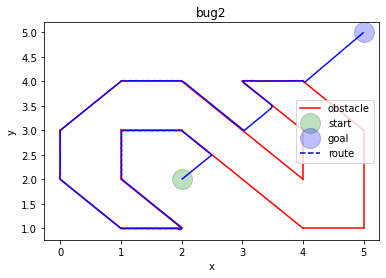

In [ ]:
obstacle = [[1, 1], [2, 1], [1, 2], [1, 3], [2, 3], 
            [4, 1], [5, 1], [5, 3], [4, 4], [3, 4], 
            [4, 3], [4, 2], [2, 4], [1, 4], [0, 3], [0, 2]]
plotRobotRoute([2.0, 2.0], [5.0, 5.0], obstacle, 0.05, math.pi/10)

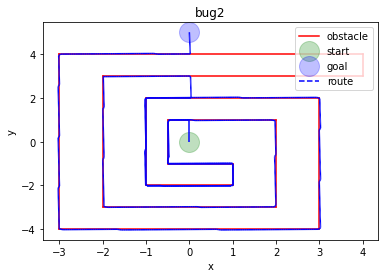

In [ ]:
obstacle = [[1, -1], [-0.5, -1], [-0.5, 1], [2, 1], [2, -3], 
            [-2, -3], [-2, 3], [4, 3], [4, 4], [-3, 4], [-3, -4], 
            [3, -4], [3, 2], [-1, 2], [-1, -2], [1, -2]]
plotRobotRoute([0.0, 0.0], [0.0, 5.0], obstacle, 0.05, math.pi/10)

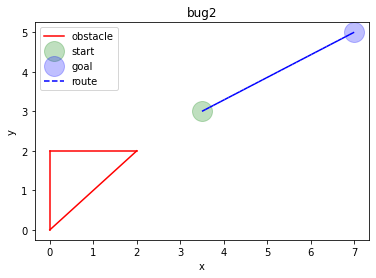

In [ ]:
plotRobotRoute([3.5, 3.0], [7.0, 5.0], [[0, 0], [2, 2], [0, 2]], 0.1, math.pi/10)